In [22]:
import numpy as np
import networkx as nx
from graph_routing_gym import GraphRoutingEnv
import dgl
import dgl.function as fn
from dgl.nn.pytorch import GraphConv
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


0


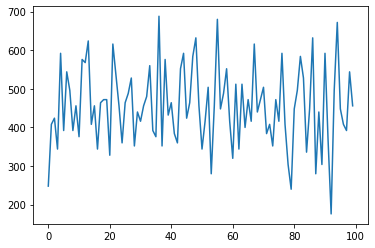

In [23]:
P = nx.petersen_graph()
# nx.draw(P, with_labels=True)
env = GraphRoutingEnv(P)
returns = []
for i in range(100):
    total = 0
    if i % 100 == 0:
        print(i)
    env.reset()
    done = False
    while not done:
        obs, reward, done = env.step(env.sample_action())
        total += reward
    returns.append(total)

plt.plot(returns)
plt.show()

In [29]:
class GcnDqn(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(GcnDqn, self).__init__()
        self.conv1 = GraphConv(in_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        g.ndata['h'] = torch.zeros((g.number_of_nodes(), len(g.edata["feat"][0])))
        g.update_all(fn.u_add_e('h', 'feat', 'm'), fn.sum('m', 'h'))
        # Perform graph convolution and activation function.
        h = g.ndata['h']
        h = F.relu(self.conv1(g, h))
        h = F.relu(self.conv2(g, h))
        g.ndata['h'] = h
        # Calculate graph representation by averaging all the node representations.
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)

In [30]:
obs = env.reset()
net = GcnDqn(env.feature_size, 10, env.k)
net(obs)

tensor([[-17.7832,  76.0548, -78.3616,  69.3977]], grad_fn=<AddmmBackward>)